<img src="fuellogo.svg" style="float:left; padding-right:1em;" width=150 />

# AIRPLANE FUEL
*Minimize fuel burn for a plane that can sprint and land quickly.*

### Set up the modelling environment

First we'll to import GPkit and turn on $\LaTeX$ printing for GPkit variables and equations.

In [1]:
import numpy as np
from gpkit import Variable, VectorVariable, GP
import gpkit.interactive
%pylab inline
gpkit.interactive.init_printing()

Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


### declare constants

In [2]:
N_lift         = Variable("N_{lift}", 6.0, "-", "Wing loading multiplier")
pi             = Variable("\\pi", np.pi, "-", "Half of the circle constant")
sigma_max      = Variable("\\sigma_{max}", 250e6, "Pa", "Allowable stress, 6061-T6")
sigma_maxshear = Variable("\\sigma_{max,shear}", 167e6, "Pa", "Allowable shear stress")
g              = Variable("g", 9.8, "m/s^2", "Gravitational constant")
w              = Variable("w", 0.5, "-", "Wing-box width/chord")
r_h            = Variable("r_h", 0.75, "-", "Wing strut taper parameter")
f_wadd         = Variable("f_{wadd}", 2, "-", "Wing added weight fraction")
W_fixed        = Variable("W_{fixed}", 14.7e3, "N", "Fixed weight")
C_Lmax         = Variable("C_{L,max}", 1.5, "-", "Maximum C_L, flaps down")
rho            = Variable("\\rho", 0.91, "kg/m^3", "Air density, 3000m")
rho_sl         = Variable("\\rho_{sl}", 1.23, "kg/m^3", "Air density, sea level")
rho_alum       = Variable("\\rho_{alum}", 2700, "kg/m^3", "Density of aluminum")
mu             = Variable("\\mu", 1.69e-5, "kg/m/s", "Dynamic viscosity, 3000m")
e              = Variable("e", 0.95, "-", "Wing spanwise efficiency")
A_prop         = Variable("A_{prop}", 0.785, "m^2", "Propeller disk area")
eta_eng        = Variable("\\eta_{eng}", 0.35, "-", "Engine efficiency")
eta_v          = Variable("\\eta_v", 0.85, "-", "Propeller viscous efficiency")
h_fuel         = Variable("h_{fuel}", 42e6, "J/kg", "fuel heating value")
V_sprint_reqt  = Variable("V_{sprintreqt}", 150, "m/s", "sprint speed requirement")
W_pay          = Variable("W_{pay}", 500*9.81, "N")
R_min          = Variable("R_{min}", 1e6, "m", "Minimum airplane range")
V_stallmax     = Variable("V_{stall,max}", 40, "m/s", "Stall speed")
# sweep variables
R_min          = Variable("R_{min}", 5e6, "m", "Minimum airplane range")
V_stallmax     = Variable("V_{stall,max}", 40, "m/s", "Stall speed")

### declare free variables

In [3]:
V        = VectorVariable(3, "V", "m/s", "Flight speed")
C_L      = VectorVariable(3, "C_L", "-", "Wing lift coefficent")
C_D      = VectorVariable(3, "C_D", "-", "Wing drag coefficent")
C_Dfuse  = VectorVariable(3, "C_{D_{fuse}}", "-", "Fuselage drag coefficent")
C_Dp     = VectorVariable(3, "C_{D_p}", "-", "drag model parameter")
C_Di     = VectorVariable(3, "C_{D_i}", "-", "drag model parameter")
T        = VectorVariable(3, "T", "N", "Thrust force")
Re       = VectorVariable(3, "Re", "-", "Reynold's number")
W        = VectorVariable(3, "W", "N", "Aircraft weight")
eta_i    = VectorVariable(3, "\\eta_i", "-", "Aircraft efficiency")
eta_prop = VectorVariable(3, "\\eta_{prop}", "-")
eta_0    = VectorVariable(3, "\\eta_0", "-")
W_fuel   = VectorVariable(2, "W_{fuel}", "N", "Fuel weight")
z_bre    = VectorVariable(2, "z_{bre}", "-")
S        = Variable("S", "m^2", "Wing area")
R        = Variable("R", "m", "Airplane range")
A        = Variable("A", "-", "Aspect Ratio")
I_cap    = Variable("I_{cap}", "m^4", "Spar cap area moment of inertia per unit chord")
M_rbar   = Variable("\\bar{M}_r", "-")
P_max    = Variable("P_{max}", "W")
V_stall  = Variable("V_{stall}", "m/s")
nu       = Variable("\\nu", "-")
p        = Variable("p", "-")
q        = Variable("q", "-")
tau      = Variable("\\tau", "-")
t_cap    = Variable("t_{cap}", "-")
t_web    = Variable("t_{web}", "-")
W_cap    = Variable("W_{cap}", "N")
W_zfw    = Variable("W_{zfw}", "N", "Zero fuel weight")
W_eng    = Variable("W_{eng}", "N")
W_mto    = Variable("W_{mto}", "N", "Maximum takeoff weight")
W_pay    = Variable("W_{pay}", "N")
W_tw     = Variable("W_{tw}", "N")
W_web    = Variable("W_{web}", "N")
W_wing   = Variable("W_{wing}", "N")

Let's check that the vector constraints are working:

In [4]:
W == 0.5*rho*C_L*S*V**2

[W_(0,) == 0.5*C_L_(0,)*S*V_(0,)**2*\rho, W_(1,) == 0.5*C_L_(1,)*S*V_(1,)**2*\
rho, W_(2,) == 0.5*C_L_(2,)*S*V_(2,)**2*\rho]

### Form the optimization problem

In the 3-element vector variables, indices 0, 1, and 2 are the outbound, return and sprint flights.

In [5]:
steady_level_flight = (W == 0.5*rho*C_L*S*V**2,
                       T >= 0.5*rho*C_D*S*V**2,
                       Re == (rho/mu)*V*(S/A)**0.5)

landing_fc = (W_mto <= 0.5*rho_sl*V_stall**2*C_Lmax*S,
              V_stall <= V_stallmax)

sprint_fc = (P_max >= T[2]*V[2]/eta_0[2],
             V[2] >= V_sprint_reqt)

drag_model = (C_D >= (0.05/S)*gpkit.units.m**2 +C_Dp + C_L**2/(pi*e*A),
              1 >= (2.56*C_L**5.88/(Re**1.54*tau**3.32*C_Dp**2.62) +
                   3.8e-9*tau**6.23/(C_L**0.92*Re**1.38*C_Dp**9.57) +
                   2.2e-3*Re**0.14*tau**0.033/(C_L**0.01*C_Dp**0.73) +
                   1.19e4*C_L**9.78*tau**1.76/(Re*C_Dp**0.91) +
                   6.14e-6*C_L**6.53/(Re**0.99*tau**0.52*C_Dp**5.19)))

propulsive_efficiency = (eta_0 <= eta_eng*eta_prop,
                         eta_prop <= eta_i*eta_v,
                         4*eta_i + T*eta_i**2/(0.5*rho*V**2*A_prop) <= 4)

# 4th order taylor approximation for e^x
z_bre_sum = 0
for i in range(1,5):
    z_bre_sum += z_bre**i/np.math.factorial(i)

range_constraints = (R >= R_min,
                     z_bre >= g*R*T[:2]/(h_fuel*eta_0[:2]*W[:2]),
                     W_fuel/W[:2] >= z_bre_sum)

weight_relations = (W_pay >= 500*g*gpkit.units.kg,
                    W_tw >= W_fixed + W_pay + W_eng,
                    W_zfw >= W_tw + W_wing,
                    W_eng >= 0.0372*P_max**0.8083 * gpkit.units.parse_expression('N/W^0.8083'),
                    W_wing/f_wadd >= W_cap + W_web,
                    W[0] >= W_zfw + W_fuel[1],
                    W[1] >= W_zfw,
                    W_mto >= W[0] + W_fuel[0],
                    W[2] == W[0])

wing_structural_model = (2*q >= 1 + p,
                         p >= 2.2,
                         tau <= 0.25,
                         M_rbar >= W_tw*A*p/(24*gpkit.units.N),
                         .92**2/2.*w*tau**2*t_cap >= I_cap * gpkit.units.m**-4 + .92*w*tau*t_cap**2,
                         8 >= N_lift*M_rbar*A*q**2*tau/S/I_cap/sigma_max * gpkit.units.parse_expression('Pa*m**6'),
                         12 >= A*W_tw*N_lift*q**2/tau/S/t_web/sigma_maxshear,
                         nu**3.94 >= .86*p**-2.38 + .14*p**0.56,
                         W_cap >= 8*rho_alum*g*w*t_cap*S**1.5*nu/3/A**.5,
                         W_web >= 8*rho_alum*g*r_h*tau*t_web*S**1.5*nu/3/A**.5
                         )

In [6]:
eqns = (weight_relations + range_constraints + propulsive_efficiency
        + drag_model + steady_level_flight + landing_fc + sprint_fc + wing_structural_model)

gp = gpkit.GP(W_fuel.sum(), eqns)

### Design an airplane

In [7]:
sol = gp.solve(solver='mosek')

Using solver 'mosek'
Solving for 55 variables.
Solving took 0.0835 seconds.


The "local model" is the power-law tangent to the Pareto frontier, gleaned from sensitivities.

In [8]:
#sol["local_model"][0].sub(gp.substitutions)

### plot design frontiers

In [9]:
# %matplotlib inline
# %config InlineBackend.figure_format = 'retina'

# plot_frontiers = gpkit.interactive.plot_frontiers
# plot_frontiers(gp, [V[0], V[1], V[2]])
# plot_frontiers(gp, [S, W_zfw, P_max])
# plot_frontiers(gp, ['S{\\rho_{alum}}', 'S{h_{fuel}}', 'S{A_{prop}}'])

### Interactive analysis

Let's investigate it with the [cadtoons](https://github.com/bqpd/cadtoons) library. Running `cadtoon.py flightconditions.svg` in this folder creates an interactive SVG graphic for us.

First, import the functions to display HTML in iPython Notebook, and the [ractivejs](http://www.ractivejs.org/) library.

In [10]:
from string import Template

fuelupdate_js = Template("""
var W_eng = $W_eng,
    lam = $lam

fuel.shearinner.scalex = 1-$tcap*10
fuel.shearinner.scaley = 1-$tweb*100
fuel.airfoil.scaley = $tau/0.13
fuel.fuse.scalex = $W_fus/24000
fuel.wing.scalex = $b/2/14
fuel.wing.scaley = $cr*1.21
""")

def fuelupdate_py(sol):
    varstrs = "p", "S", "A", "t_{cap}", "t_{web}", "w", "\\tau", "W_{eng}", "W_{mto}", "W_{wing}"
    p, S, A, t_cap, t_web, w, tau, W_eng, W_mto, W_wing = sol.getvars(*varstrs)
    lam = 0.5*(p-1)
    return fuelupdate_js.substitute(lam = lam,
                                    b = (S*A)**0.5,
                                    cr = 2/(1+lam)*(S/A)**0.5,
                                    tcap = t_cap/tau,
                                    tweb = t_web/w,
                                    tau = tau,
                                    W_eng = W_eng,
                                    W_fus = W_mto - W_wing - W_eng)

fuelconstraint_js = """
fuel.engine1.scale = Math.pow(W_eng/3000, 2/3)
fuel.engine2.scale = Math.pow(W_eng/3000, 2/3)
fuel.engine1.y = 6*lam
fuel.engine2.y = 6*lam
fuel.wingrect.scaley = 1-lam
fuel.wingrect.y = -6 + 5*lam
fuel.wingtaper.scaley = lam
fuel.wingtaper.y = 5*lam
"""

In [11]:
gpkit.interactive.showcadtoon("fuel",
"position:absolute; height:0; right:0; top:24em;")

In [12]:
gpkit.interactive.ractorpy(gp, fuelupdate_py,
         {"V_{stall,max}": (20, 50, 0.3),
          "R_{min}": (1e6, 1e7, 1e5),
          "V_{sprintreqt}": (100, 200, 1)},
         fuelconstraint_js)


Cost
----
 9144 [N] 

Constant and swept variable sensitivities
-----------------------------------------
          A_{prop} : -0.147   Propeller disk area         
         C_{L,max} : -0.3388  Maximum C_L, flaps down     
          N_{lift} : 0.3892   Wing loading multiplier     
           R_{min} : 1.207    Minimum airplane range      
    V_{sprintreqt} : 0.5452   sprint speed requirement    
     V_{stall,max} : -0.6777  Stall speed                 
         W_{fixed} : 0.8232   Fixed weight                
            \eta_v : -1.39    Propeller viscous efficiency
        \eta_{eng} : -1.39    Engine efficiency           
               \mu : 0.05899  Dynamic viscosity, 3000m    
               \pi : -0.6053  Half of the circle constant 
              \rho : 0.1516   Air density, 3000m          
       \rho_{alum} : 0.3764   Density of aluminum         
         \rho_{sl} : -0.3388  Air density, sea level      
\sigma_{max,shear} : -0.01447 Allowable shear stress      
      \s

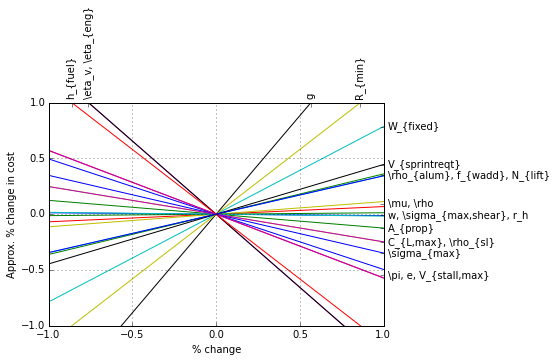

In [15]:
from gpkit.interactive.plotting import sensitivity_plot
_ = sensitivity_plot(gp)

In [13]:
# gpkit.interactive.ractorjs("fuel", gp, fuelupdate_py,
#          {"V_{stall,max}": (20, 50, 3),
#           "R_{min}": (1e6, 1e7, 2e6),
#           "V_{sprintreqt}": (100, 200, 20)},
#          fuelconstraint_js)

This concludes the aircraft example. Try playing around with the sliders up above until you're bored; then check out one of the other examples. Thanks for reading!

### Import CSS for nbviewer

If you have a local iPython stylesheet installed, this will add it to the iPython Notebook:

In [16]:
from IPython import utils
from IPython.core.display import HTML
import os
def css_styling():
    """Load default custom.css file from ipython profile"""
    base = utils.path.get_ipython_dir()
    styles = "<style>\n%s\n</style>" % (open(os.path.join(base,'profile_default/static/custom/custom.css'),'r').read())
    return HTML(styles)
css_styling()